In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *   #lit,col,expr,regexp_extract,regexp_replace,current_date, current_timestamp,date_format
from pyspark.sql.types import StructField,StringType,StructType,DoubleType,LongType,IntegerType,FloatType,TimestampType,DataType
import pyspark
import psycopg2

In [2]:
host = "containers-us-west-135.railway.app"
port = "6386"
database = "railway"
user = "postgres"
password = "5gnySTpVjr8O5V4ulmD0"

In [3]:
spark= SparkSession.builder.appName("BaseDatos").getOrCreate()

In [4]:
jdbc_url = f"jdbc:postgresql://{host}:{port}/{database}"
connection_properties = {
    "user": user,
    "password": password,
    "driver": "org.postgresql.Driver"
}

In [5]:
Base_Datos_Inventario=spark.read \
    .format("jdbc")  \
    .option("url", jdbc_url) \
    .option("dbtable", 'Base_Datos_Inventario') \
    .option("user",user) \
    .option("password",password) \
    .load()

In [6]:
Base_Datos_Inventario.cache()

DataFrame[NegocioInventarios: string, Material: string, TipoMaterialInventario: string, Descripcion: string, Lote: string, Fechaentrada: string, CostoUnitarioReal: int, InventarioDisponible: float, InventarioNoDisponible: float, ValorObsoleto: float, ValorBloqueadoMM: float, ValorTotalMM: float, Permanencia: int, Cliente: string, ClaseBaseRiesgo: string, BasedeRiesgo: string, BRPesos: float]

In [7]:
Base_Datos_Inventario=Base_Datos_Inventario.select(col('*'),
                            date_format(to_date('Fechaentrada',"d/M/yyy"),"MMMM").alias('Mes'),
                            date_format(to_date('Fechaentrada',"d/M/yyy"),"y").alias('Año')).drop('Descripcion','Fechaentrada')

In [8]:
Base_Datos_Inventario.createOrReplaceTempView("Base_Datos_Inventario")

In [9]:
Base_Datos_Inventario.printSchema()

root
 |-- NegocioInventarios: string (nullable = true)
 |-- Material: string (nullable = true)
 |-- TipoMaterialInventario: string (nullable = true)
 |-- Lote: string (nullable = true)
 |-- CostoUnitarioReal: integer (nullable = true)
 |-- InventarioDisponible: float (nullable = true)
 |-- InventarioNoDisponible: float (nullable = true)
 |-- ValorObsoleto: float (nullable = true)
 |-- ValorBloqueadoMM: float (nullable = true)
 |-- ValorTotalMM: float (nullable = true)
 |-- Permanencia: integer (nullable = true)
 |-- Cliente: string (nullable = true)
 |-- ClaseBaseRiesgo: string (nullable = true)
 |-- BasedeRiesgo: string (nullable = true)
 |-- BRPesos: float (nullable = true)
 |-- Mes: string (nullable = true)
 |-- Año: string (nullable = true)



In [10]:
# Base_Datos_Inventario.columns
# for i in Base_Datos_Inventario.columns:
#     spark.sql("SELECT count({0}) AS {0} FROM Base_Datos_Inventario WHERE {0} is NULL".format(i)).show(1)

# Datos Descriptivos y exploratorios

In [11]:
inputcols=['CostoUnitarioReal','InventarioDisponible','InventarioNoDisponible',
                        'ValorObsoleto','ValorBloqueadoMM','Permanencia','BRPesos']

In [12]:
Base_Datos_Inventario[['CostoUnitarioReal','InventarioDisponible','InventarioNoDisponible',
                        'ValorObsoleto','ValorBloqueadoMM','ValorTotalMM','Permanencia','BRPesos']].describe().toPandas()

,summary,CostoUnitarioReal,InventarioDisponible,InventarioNoDisponible,ValorObsoleto,ValorBloqueadoMM,ValorTotalMM,Permanencia,BRPesos
0,count,704975,704975,704975,704975,704975,658464,704975,704975
1,mean,41705.41556934643,5147.851974618004,143.73275048397954,0.05760267914243626,0.01993835274749658,1.9213958345847975,539.7244015745239,0.3706911592609667
2,stddev,859749.734814134,134113.89418113086,11701.48541252973,0.8546298804118816,0.7145676101471892,9.09804648454944,648.234950080117,3.7672935571505577
3,min,0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,max,96060887,1.85464E7,7944000.0,147.2064,154.58832,595.82904,5597,406.0


In [13]:
import matplotlib.pyplot as plt
import seaborn as sb

inputcols=Base_Datos_Inventario[inputcols].drop('ValorTotalMM').columns
dic={}
for i in inputcols:
    dic[i]=Base_Datos_Inventario[['CostoUnitarioReal','InventarioDisponible','InventarioNoDisponible',
                        'ValorObsoleto','ValorBloqueadoMM','ValorTotalMM','Permanencia','BRPesos']].stat.corr('ValorTotalMM',i)    #Credit_Limit
dic

{'CostoUnitarioReal': 0.014184583267925828,
 'InventarioDisponible': 0.15634414574358924,
 'InventarioNoDisponible': 0.02473781227635128,
 'ValorObsoleto': 0.07600961419623711,
 'ValorBloqueadoMM': 0.08199653261584916,
 'Permanencia': -0.12229195764110684,
 'BRPesos': 0.402686246310465}

<AxesSubplot:>

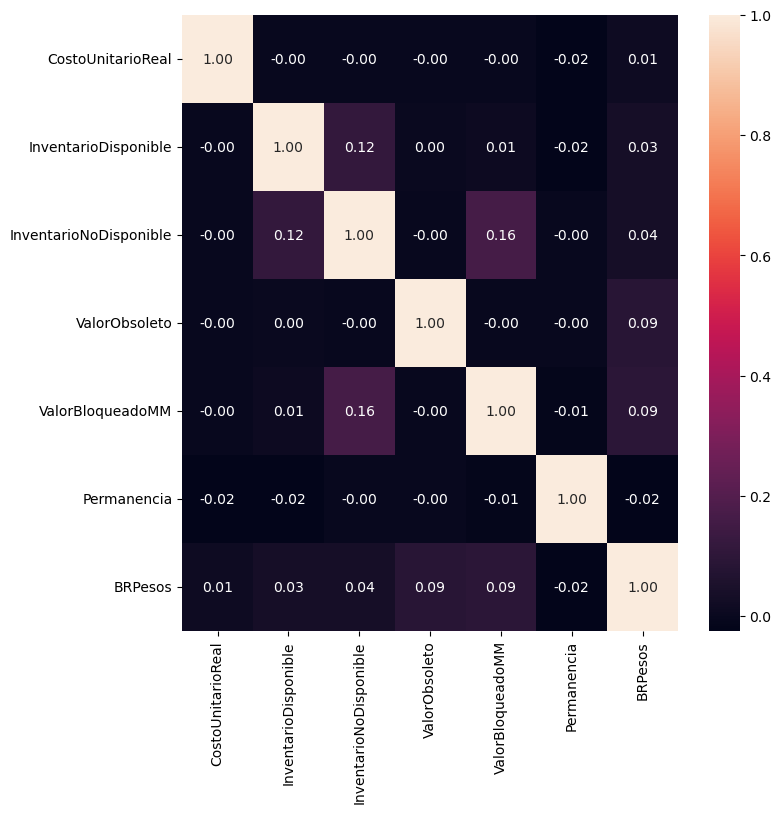

In [14]:
corr=Base_Datos_Inventario[[inputcols]].toPandas().corr()
fig,axes=plt.subplots(figsize=(8,8))
sb.heatmap(corr,annot=True,fmt='.2f')

## Aplicar Trasformadores, estimadores y evaluadores

In [15]:
import warnings
warnings.filterwarnings("ignore")
from pyspark.ml.feature import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import UnivariateFeatureSelector

In [16]:
Base_Datos_Inventario=Base_Datos_Inventario.select(col('*'),(col('ValorTotalMM')*10000000).alias('Valor'))

In [21]:
data_categoric_inp=['NegocioInventarios','Material','TipoMaterialInventario','Lote',
                    'Cliente','ClaseBaseRiesgo','BasedeRiesgo','Mes','Año']
data_categoric_out=['NegocioInventarios_Bin','Material_Bin','TipoMaterialInventario_Bin','Lote_Bin',
                   'Cliente_Bin','ClaseBaseRiesgo_Bin','BasedeRiesgo_Bin','Mes_Bin','Año_Bin']
data_numeric=['CostoUnitarioReal','InventarioDisponible','InventarioNoDisponible',
                'ValorObsoleto','ValorBloqueadoMM','BRPesos']  #'Permanencia' out 
data_string=StringIndexer(inputCols=data_categoric_inp,outputCols=data_categoric_out,handleInvalid="keep")
data_vector=VectorAssembler(inputCols=data_numeric+data_categoric_out,outputCol="Vector")
#
# selector=UnivariateFeatureSelector(featuresCol="Vector",outputCol="selectedFeatures",
#                                     labelCol='Permanencia',selectionMode="fpr")
#
minmax_scaler=MinMaxScaler(min=0,max=1,inputCol="Vector",outputCol="Features")
polynomial_expansion = PolynomialExpansion(degree=2, inputCol="Features", outputCol="polyFeatures")

In [24]:
# Define los porcentajes de partición
p1 = 0.70  # 70%
p2 = 0.30  # 30%

# Divide el DataFrame en tres DataFrames más pequeños utilizando el método sample
data_train = Base_Datos_Inventario.sample(False, p1)
data_test = Base_Datos_Inventario.sample(False, p2)
LR=LinearRegression(featuresCol="polyFeatures",labelCol='Permanencia',maxIter=30,regParam=0.30,elasticNetParam=0.85)
Pipeline_LR=Pipeline(stages=[data_string,data_vector,minmax_scaler,polynomial_expansion,LR])

In [25]:
Model_LR=Pipeline_LR.fit(data_train)

In [26]:
Prediction_LR=Model_LR.transform(data_test)

In [27]:
Prediction_LR[['Permanencia','prediction']].show()

+-----------+------------------+
|Permanencia|        prediction|
+-----------+------------------+
|        643|1040.1141950803647|
|        414|   1342.4236135032|
|        422| 988.3767916096053|
|        381| 982.3595766343512|
|        275| 989.5909343588194|
|        355|1228.5007055144665|
|        577| 492.8515595900866|
|        576| 497.3287195827652|
|        565| 495.7927071413987|
|        564|494.83046381275165|
|        562|497.64522980411556|
|        508| 950.6019932220468|
|        480| 946.9752889252136|
|         88|418.28435719333635|
|         46| 317.6089901042415|
|         11| 357.3687917345641|
|         67| 713.6801478362896|
|          0| 577.8898686494424|
|        226| 38.37514512388162|
|         45| 511.0683658150256|
+-----------+------------------+
only showing top 20 rows



In [28]:
from pyspark.ml.evaluation import RegressionEvaluator
LR_evaluater=RegressionEvaluator(labelCol='Permanencia',predictionCol='prediction',metricName="r2")
LR_evaluater.evaluate(Prediction_LR)

0.3630154374617053

In [ ]:
intercept=Model_LR.stages[-1].intercept
coefic=Model_LR.stages[-1].coefficients
intercept,coefic

In [ ]:

Model_LR.save("Model_LR_Inventario")

# Desicion Tree